<a href="https://colab.research.google.com/github/aliabdelmonam/Poisonous_Mushrooms/blob/main/Poisonous_Mushrooms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Libraries**

In [57]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.2 MB/s eta 0:00:00


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import copy


## Data

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# df=pd.read_csv('/content/sample_submission.csv')
ts=pd.read_csv('/content/drive/MyDrive/DataSet/Poisonous Mushrooms_test.csv')
tr=pd.read_csv('/content/drive/MyDrive/DataSet/Poisonous Mushrooms_train.csv')


In [5]:
tr.shape

(3116945, 22)

In [6]:
tr.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [7]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [8]:
df_train = copy.deepcopy(tr)
df_test = copy.deepcopy(ts)

# **Category**

In [11]:
def subclass_details (df):
  df=df.select_dtypes(include='category')
  for col in df.columns:
    print('Number of unique classes:',df[col].nunique())
    print(df[col].value_counts().head(10))
    print('############################')

In [12]:
def remove_att(df,threshold=200):
  cat_coln=df.select_dtypes(include='object')
  for col in cat_coln:
    attrib_drop=[]
    for att , count in df[col].value_counts().items() :
      if count <threshold:
        attrib_drop.append(att)
    mask = df[col].isin(attrib_drop)
    df.loc[mask,col] = 'UNK'
  return df

In [13]:
def convert_cate (df):
  for clas in df.select_dtypes(include='object'):
    df[clas] =   df[clas].astype('category')
  return df

In [14]:
df_train = remove_att(df_train)
df_test = remove_att(df_test)

In [15]:
df_train = convert_cate(df_train)
df_test = convert_cate(df_test)

In [ ]:
subclass_details(df_train)
subclass_details(df_test)

Number of unique classes: 2
class
p    1705396
e    1411549
Name: count, dtype: int64
############################
Number of unique classes: 8
cap-shape
x      1436026
f       676238
s       365146
b       318646
o       108835
p       106967
c       104520
UNK        527
Name: count, dtype: int64
############################
Number of unique classes: 12
cap-surface
t    460777
s    384970
y    327826
h    284460
g    263729
d    206832
k    128875
e    119712
i    113440
w    109840
Name: count, dtype: int64
############################
Number of unique classes: 13
cap-color
n    1359542
y     386627
w     379442
g     210825
e     197290
o     178847
p      91838
r      78236
u      73172
b      61313
Name: count, dtype: int64
############################
Number of unique classes: 3
does-bruise-or-bleed
f      2569743
t       547085
UNK        109
Name: count, dtype: int64
############################
Number of unique classes: 8
gill-attachment
a      646034
d      589236
x      3608

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   class                 category
 2   cap-diameter          float64 
 3   cap-shape             category
 4   cap-surface           category
 5   cap-color             category
 6   does-bruise-or-bleed  category
 7   gill-attachment       category
 8   gill-spacing          category
 9   gill-color            category
 10  stem-height           float64 
 11  stem-width            float64 
 12  stem-root             category
 13  stem-surface          category
 14  stem-color            category
 15  veil-type             category
 16  veil-color            category
 17  has-ring              category
 18  ring-type             category
 19  spore-print-color     category
 20  habitat               category
 21  season                category
dtypes: category(18), f

In [17]:
df_test.shape

(2077964, 21)

# **Missing Value**

In [29]:
def plot_missing_feature(df):
  null_df=(df.isna().sum()*100/df.shape[0]).sort_values(ascending=False)
  sns.barplot(x=null_df.index,y=null_df.values,palette='plasma')
  plt.xticks(rotation=90)
  plt.xlabel('Feature')
  plt.ylabel('Percent(%)')
  plt.title('Missing Values')
  plt.show()

In [21]:
def missing_feature (df):
  null_df=(df.isna().sum()*100/df.shape[0]).sort_values(ascending=False)
  return null_df

In [22]:
null_df_train = missing_feature(df_train)
null_df_test = missing_feature(df_test)
null_df_train

,0
veil-type,94.884350
spore-print-color,91.425482
stem-root,88.452732
veil-color,87.936970
stem-surface,63.551362
gill-spacing,40.373988
cap-surface,21.528227
gill-attachment,16.809280
ring-type,4.134818
gill-color,0.001829


<ipython-input-29-3ce396a8d97e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=null_df.index,y=null_df.values,palette='plasma')


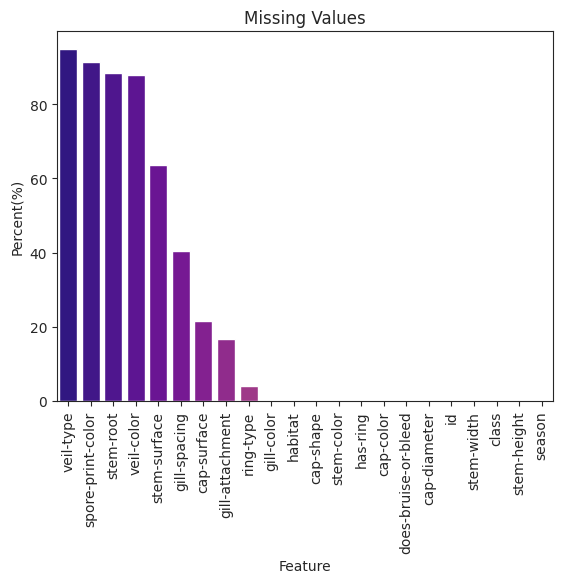

In [30]:
plot_missing_feature(df_train)

In [31]:
def columns_drop(df):
  column_drop=[]
  null_df=missing_feature(df)
  for col,val in null_df.items():
    if val >4:
      column_drop.append(col)
  return column_drop

In [32]:
column_drop_train = columns_drop(df_train)
column_drop_test = columns_drop(df_test)
print(column_drop_test)
print('-----------------------------------------')
print(column_drop_train)

['veil-type', 'spore-print-color', 'stem-root', 'veil-color', 'stem-surface', 'gill-spacing', 'cap-surface', 'gill-attachment', 'ring-type']
-----------------------------------------
['veil-type', 'spore-print-color', 'stem-root', 'veil-color', 'stem-surface', 'gill-spacing', 'cap-surface', 'gill-attachment', 'ring-type']


In [33]:
df_train.drop(column_drop_train,axis=1,inplace=True)
df_test.drop(column_drop_test,axis=1,inplace=True)
df_train.drop('id',axis=1,inplace=True)
df_test.drop('id',axis=1,inplace=True)


In [34]:
df_train.isna().sum()

,0
class,0
cap-diameter,4
cap-shape,40
cap-color,12
does-bruise-or-bleed,8
gill-color,57
stem-height,0
stem-width,0
stem-color,38
has-ring,24


In [35]:
df_test.isna().sum()

,0
cap-diameter,7
cap-shape,31
cap-color,13
does-bruise-or-bleed,10
gill-color,49
stem-height,1
stem-width,0
stem-color,21
has-ring,19
habitat,25


array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

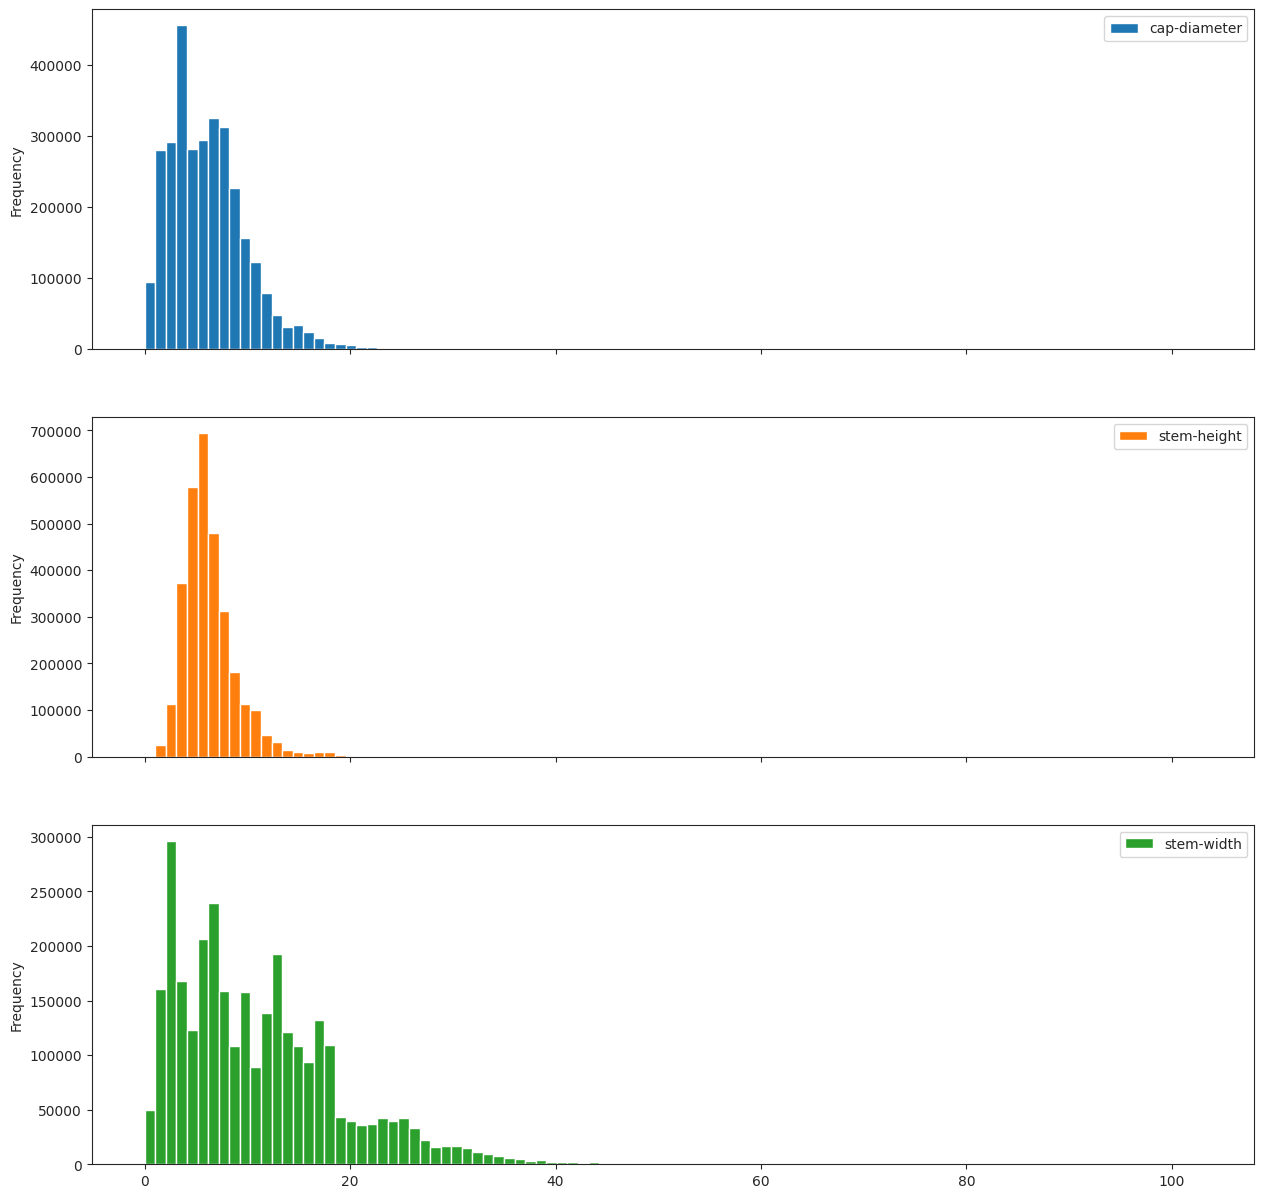

In [36]:
df_train.plot(kind='hist',subplots=True,sharex=True,figsize=(15,15),bins=100)

In [37]:
num_data_train = df_train.select_dtypes(include='number')
num_data_test = df_test.select_dtypes(include='number')
cat_data_train = df_train.select_dtypes(include='category')
cat_data_test = df_test.select_dtypes(include='category')

In [40]:
num_impute=SimpleImputer(strategy='median')
cat_impute=SimpleImputer(strategy='most_frequent')

num_data_train=pd.DataFrame(num_impute.fit_transform(num_data_train),columns=num_data_train.columns)
num_data_test=pd.DataFrame(num_impute.transform(num_data_test),columns=num_data_test.columns)
cat_data_train=pd.DataFrame(cat_impute.fit_transform(cat_data_train),columns=cat_data_train.columns)
cat_data_test=pd.DataFrame(cat_impute.fit_transform(cat_data_test),columns=cat_data_test.columns)

In [42]:
df_train = pd.concat([num_data_train,cat_data_train],axis=1).sample(frac=1)
df_test = pd.concat([num_data_test,cat_data_test],axis=1).sample(frac=1)

In [43]:
df_train.shape

(3116945, 12)

In [44]:
df_test.shape

(2077964, 11)

# **Splitting Data**

In [45]:
x=df_train.drop('class',axis=1)
y=df_train['class']
y=np.array([0 if i =='e' else 1 for i in y])
y.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [46]:
df_train=subclass_details(df_train)
df_train=subclass_details(df_test)

# **Encoding**

In [50]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2077964 entries, 1160705 to 891607
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   cap-diameter          float64
 1   stem-height           float64
 2   stem-width            float64
 3   cap-shape             object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-color            object 
 7   stem-color            object 
 8   has-ring              object 
 9   habitat               object 
 10  season                object 
dtypes: float64(3), object(8)
memory usage: 190.2+ MB


In [51]:
x.head()

,cap-diameter,stem-height,stem-width,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-color,has-ring,habitat,season
252973,12.48,10.07,23.93,x,n,t,y,n,f,d,a
104579,4.19,5.02,5.88,s,n,t,p,n,f,d,a
1424213,5.62,4.59,10.39,x,n,f,p,n,f,d,a
712984,9.43,20.55,12.67,f,w,f,p,w,t,d,u
2878250,8.27,7.06,16.57,f,u,f,y,u,f,d,a


In [52]:
encoding=LabelEncoder()
for col in x.select_dtypes(include='object').columns:
  x[col]=encoding.fit_transform(x[col])
  df_test[col]=encoding.transform(df_test[col])

In [53]:
x.shape

(3116945, 11)

In [55]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=(2077964/3116945),stratify=y)

In [56]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2077964, 11)
(2077964,)
(1038981, 11)
(1038981,)


In [59]:
def Bayesian_Optimization (model,search_space):
  bayes = BayesSearchCV(model,
                        search_space,
                         n_iter= 20
                        n_jobs=-1,
                        scoring='accuracy',
                        random_state=42)
  return bayes

In [60]:
xgb_space = {
    'n_estimators': Integer(50, 150),
    'max_depth': Integer(2, 8),
    'learning_rate': Real(0.01, .4, 'log-uniform'),
    'subsample': Real(0.5, 1.0, 'uniform'),
    'colsample_bytree': Real(0.5, 1.0, 'uniform')
}

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb_optimzied = Bayesian_Optimization(xgb,xgb_space)
xgb_optimzied.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
